<a href="https://colab.research.google.com/github/Sergrey5571/Sergrey5571/blob/main/%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание Pro

Добейтесь точности распознавания 97% и верно распознанных всех писателей с помощью любой нейронной сети. 

Загрузка библиотек:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, RMSprop
from tensorflow.keras.layers import Dense, Dropout,Embedding, SpatialDropout1D, BatchNormalization, Flatten, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split
from google.colab import files
from google.colab import drive
import time
%matplotlib inline


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q '/content/drive/MyDrive/БАЗЫ/Тексты писателей-20211108T091101Z-001.zip' -d '/content/texts'

In [ ]:
def readText(fileName):
  f = open(fileName, 'r')
  text = f.read()
  text = text.replace('\n', ' ')
  return text

In [ ]:
className = ['О. Генри', 'Стругацкие', 'Булгаков', 'Саймак', 'Фрай', 'Брэдберри']
nClasses = len(className)

In [ ]:
trainText = []
testText = []
for i in className:
  for j in os.listdir('texts/Тексты писателей'):
    if i in j:
      if 'Обучающая' in j:
        trainText.append(readText('texts/Тексты писателей/' + j))
        print(j, 'Обучающая')
      if 'Тестовая' in j:
        testText.append(readText('texts/Тексты писателей/' + j))
        print(j, 'Тестовая')
  print()      

(О. Генри) Обучающая_50 вместе.txt Обучающая
(О. Генри) Тестовая_20 вместе.txt Тестовая

(Стругацкие) Тестовая_2 вместе.txt Тестовая
(Стругацкие) Обучающая_5 вместе.txt Обучающая

(Булгаков) Тестовая_2 вместе.txt Тестовая
(Булгаков) Обучающая_5 вместе.txt Обучающая

(Клиффорд_Саймак) Тестовая_2 вместе.txt Тестовая
(Клиффорд_Саймак) Обучающая_5 вместе.txt Обучающая

(Макс Фрай) Обучающая_5 вместе.txt Обучающая
(Макс Фрай) Тестовая_2 вместе.txt Тестовая

(Рэй Брэдберри) Обучающая_22 вместе.txt Обучающая
(Рэй Брэдберри) Тестовая_8 вместе.txt Тестовая



In [ ]:
maxWordsCount = 20000  
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0\ufeff',
                      lower=True, split=' ', oov_token = 'unknown', char_level = False)
tokenizer.fit_on_texts(trainText)
items = list(tokenizer.word_index.items())
print(len(items))
print(items[2001:2015])

144136
[('попробовать', 2002), ('вашем', 2003), ('работал', 2004), ('замолчал', 2005), ('видит', 2006), ('спорить', 2007), ('старой', 2008), ('послать', 2009), ('смотрю', 2010), ('поезд', 2011), ('гордо', 2012), ('каждому', 2013), ('ответа', 2014), ('случаях', 2015)]


In [ ]:
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)

In [ ]:
print(trainText[4][20:80])
print(trainWordIndexes[2][30:50])

   – С тех пор как меня угораздило побывать в этой грешной Ч
[2837, 7, 51, 1, 7, 1174, 1, 7, 1676, 1, 1616, 1, 1, 2, 1, 96, 3425, 933, 19, 1]


In [ ]:
def getSetFromIndexes(wordIndexes, xlen, step): # образуем цепочки xLen с шагом step
  xSample = []
  wordslen = len(wordIndexes)
  index = 0
  while (index + xlen <= wordslen):
    xSample.append(wordIndexes[index:index + xlen])
    index+=step
  return xSample

In [ ]:
def createSetMultiClasses(wordIndexes, xlen, step):
  nClasses = len(wordIndexes)
  classesXSample = []
  for WI in wordIndexes:
    classesXSample.append(getSetFromIndexes(WI, xlen, step))
  xSamples = []
  ySamples = []
  for t in range(nClasses):
    xT = classesXSample[t]
    for i in range(len(xT)):
      xSamples.append(xT[i])
      ySamples.append(utils.to_categorical(t, nClasses))
  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)
  return (xSamples, ySamples)

In [ ]:
xLen = 8000
step = 100
xTrain, yTrain = createSetMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetMultiClasses(testWordIndexes, xLen, step)
print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)
print(xTrain.size)

(18088, 8000)
(6611, 8000)
(18088, 6)
(6611, 6)
144704000


In [ ]:
xTrain_1 = tokenizer.sequences_to_matrix(xTrain.tolist())
xTest_1 = tokenizer.sequences_to_matrix(xTest.tolist())
print(xTrain_1.shape)
print(xTrain_1[1][:80])

(18088, 20000)
[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 1. 1.]


# моделька:

In [ ]:
model = Sequential()
model.add(Dense(256, input_dim = maxWordsCount, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer = Adadelta(learning_rate=0.2), metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 256)               5120256   
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_40 (Dense)            (None, 128)               32896     
                                                                 
 dense_41 (Dense)            (None, 6)                 774       
                                                                 
Total params: 5,153,926
Trainable params: 5,153,926
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(xTrain_1, yTrain, batch_size=192, epochs=10, validation_data=(xTest_1, yTest))

Epoch 1/10
95/95 [==============================] - 1s 16ms/step - loss: 1.4931e-05 - accuracy: 1.0000 - val_loss: 0.1345 - val_accuracy: 0.9738
Epoch 2/10
95/95 [==============================] - 1s 11ms/step - loss: 1.5301e-05 - accuracy: 1.0000 - val_loss: 0.1321 - val_accuracy: 0.9752
Epoch 3/10
95/95 [==============================] - 1s 11ms/step - loss: 1.5458e-05 - accuracy: 1.0000 - val_loss: 0.1314 - val_accuracy: 0.9752
Epoch 4/10
95/95 [==============================] - 1s 11ms/step - loss: 1.5262e-05 - accuracy: 1.0000 - val_loss: 0.1309 - val_accuracy: 0.9750
Epoch 5/10
95/95 [==============================] - 1s 10ms/step - loss: 1.4371e-05 - accuracy: 1.0000 - val_loss: 0.1312 - val_accuracy: 0.9749
Epoch 6/10
95/95 [==============================] - 1s 11ms/step - loss: 1.3502e-05 - accuracy: 1.0000 - val_loss: 0.1309 - val_accuracy: 0.9746
Epoch 7/10
95/95 [==============================] - 1s 11ms/step - loss: 1.4205e-05 - accuracy: 1.0000 - val_loss: 0.1311 - val_ac

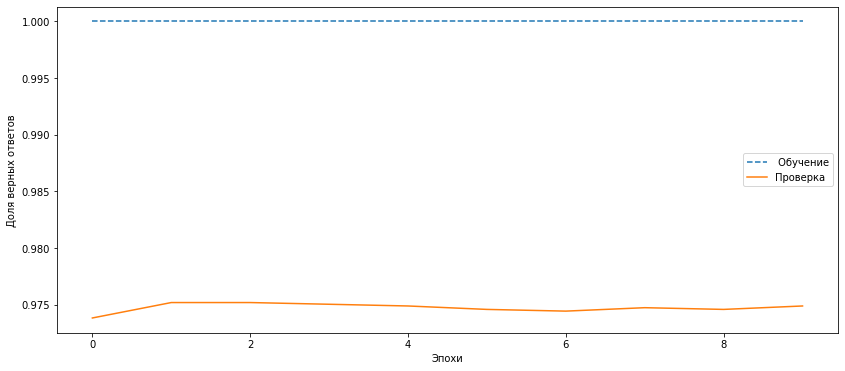

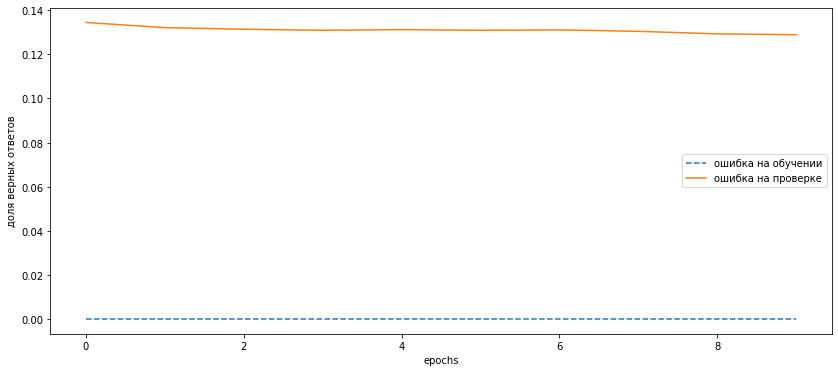

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(history.history['accuracy'], '--', label = ' Обучение')
plt.plot(history.history['val_accuracy'], label = 'Проверка')
plt.xlabel('Эпохи')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()
plt.figure(figsize=(14,6))
plt.plot(history.history['loss'], '--', label = 'ошибка на обучении')
plt.plot(history.history['val_loss'], label = 'ошибка на проверке')
plt.xlabel('epochs')
plt.ylabel('доля верных ответов')
plt.legend()
plt.show()

In [ ]:
 #тестовая выборка в удобных для распознавания размерах
def createTestMultiClasses(wordIndexes, xLen, step): 
  nClasses = len(wordIndexes) 
  xTest6Classes01 = []              
  xTest6Classes = []                 
  for wI in wordIndexes:                       
    sample = (getSetFromIndexes(wI, xLen, step)) 
    xTest6Classes.append(sample)              
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) 
  xTest6Classes01 = np.array(xTest6Classes01)                     
  xTest6Classes = np.array(xTest6Classes)                   
  
  return xTest6Classes01, xTest6Classes  

# Распознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  totalSumRec = 0 
  
  for i in range(nClasses):
    currPred = model.predict(xTest[i])
    currOut = np.argmax(currPred, axis=1)
    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))
    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal) 
    
    #по текущему классу
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')
  
  #Выводим средний процент 
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')

  print()
  
  return totalSumRec/sumCount

In [ ]:
pred = recognizeMultiClass(model, xTest6Classes01, "Тексты 01 + Dense") #Преобразование тестовой выборки

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
l = np.array(xTest6Classes01)
np.save('xTestPredictBoW', l)
np.save('xTestPredictEmbedding', x2)

In [ ]:
#Проверяем точность 
pred = recognizeMultiClass(model, xTest6Classes01, "Тексты 01 + Dense")

НЕЙРОНКА:  Тексты 01 + Dense

Класс: О. Генри   100% сеть отнесла к классу О. Генри  Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 94% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   97% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     100% сеть отнесла к классу Саймак    Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       95% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  100% сеть отнесла к классу Брэдберри Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 97%

